In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import os

In [4]:
device='cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [5]:
import torchvision.transforms as transforms
trans=transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.GaussianBlur(kernel_size=3, sigma=0.1),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [6]:
from sklearn.model_selection import train_test_split
train_data=os.listdir("/content/drive/MyDrive/DL_project/TRAIN")
all_paths=[]
all_labels=[]
for i,path in enumerate(train_data):
    full_path="/content/drive/MyDrive/DL_project/TRAIN/"+path+"/"
    lst=os.listdir(full_path)
    lst=[full_path+i for i in lst]
    all_paths.extend(lst)
    all_labels.extend([i for j in range(len(lst))])
all_paths=np.array(all_paths)
all_labels=np.array(all_labels)
train_lst,val_lst,train_labels,val_labels=train_test_split(all_paths,all_labels,test_size=0.3)
val_lst,test_lst,val_labels,test_labels=train_test_split(val_lst,val_labels,test_size=0.33)

In [7]:
class DataSet(Dataset):
    def __init__(self,paths,labels,transform=None):
        self.transform=transform
        self.images_path=paths
        self.labels=labels
        if(transform is not None):
            self.images_path=np.append(self.images_path,self.images_path)
            self.labels=np.append(self.labels,self.labels)
    def __len__(self):
        return len(self.images_path)
    def __getitem__(self,idx):
        hf=len(self.images_path)/2
        img=self.images_path[idx]
        image=cv2.imread(img)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image,(299,299), interpolation=cv2.INTER_CUBIC)
        resized_image=np.array(resized_image)
        resized_image=torch.tensor(resized_image).to(torch.float32)
        if(self.transform is not None):
            half=len(self.images_path)/2
            if(idx>=half):
                resized_image=torch.reshape(resized_image,(3,299,299))
                resized_image=self.transform(resized_image)
                return resized_image,self.labels[idx]
        resized_image=torch.reshape(resized_image,(3,299,299))
        return resized_image,self.labels[idx]

In [8]:
train_dataset=DataSet(train_lst,train_labels,trans)
val_dataset=DataSet(val_lst,val_labels,trans)
test_dataset=DataSet(test_lst,test_labels,trans)
train_dataloader=DataLoader(train_dataset,batch_size=16,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=16,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=16,shuffle=True)

3


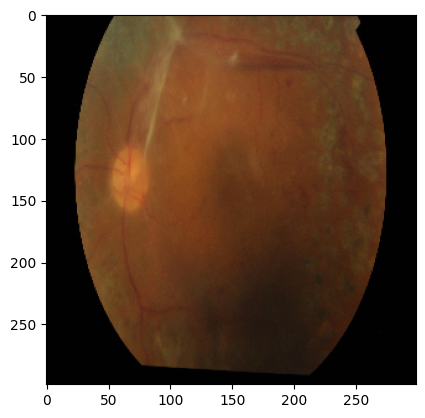

In [9]:
img,i=train_dataset.__getitem__(100)
img=np.array(img).astype(np.uint8)
img=np.reshape(img,(299,299,3))
plt.imshow(img)
print(i)

In [10]:
import warnings
warnings.filterwarnings("ignore")
import torchvision
class Resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.res=torchvision.models.resnet50(pretrained=True).to(device)
        for param in self.res.parameters():
            param.requires_grad=False
        self.classifier=nn.Sequential(
            nn.Linear(1000,50),
            nn.Dropout(0.5),
            nn.Linear(50,5)
        ).to(device)
        
    def forward(self,x):
        x=x.to(torch.float32)
        x=x.to(device)
        x=self.res(x)
        x=self.classifier(x)
        x=torch.nn.functional.softmax(x, dim=1)
        return x

In [11]:
from sklearn.metrics import accuracy_score,precision_score,f1_score
def get_acc(pred,out):
    arr=pred.to('cpu').detach()
    arr=np.array(arr)
    arr2=out.to('cpu').detach()
    arr2=np.array(arr2)
    return accuracy_score(arr,arr2)
def get_prec(pred,out):
    arr=pred.to('cpu').detach()
    arr=np.array(arr)
    arr2=out.to('cpu').detach()
    arr2=np.array(arr2)
    return precision_score(arr,arr2,average='macro')
def get_f1(pred,out):
    arr=pred.to('cpu').detach()
    arr=np.array(arr)
    arr2=out.to('cpu').detach()
    arr2=np.array(arr2)
    return f1_score(arr,arr2,average='macro')

In [12]:
def train(model,train_dataloader,epochs,optimizer,criterion,val_loader):
    tr_acc_l=[]
    tr_loss_l=[]
    tr_prec_l=[]
    tr_f1_l=[]
    val_acc_l=[]
    val_prec_l=[]
    val_f1_l=[]
    val_loss_l=[]
    for ep in range(epochs):  
        model.train()
        running_loss = 0.0
        tr_acc=0
        tr_prec=0
        tr_f1=0
        for i,data in enumerate(train_dataloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs=outputs.to('cpu')
            labels=labels.to(torch.long)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            outputs=torch.argmax(outputs,dim=1)
            tr_acc+=get_acc(outputs,labels)
            tr_prec+=get_prec(outputs,labels)
            tr_f1+=get_f1(outputs,labels)
            if(i%25==0):
                sen = f"Training Epochs:{ep} Mini Batch {i+1},Running Loss {running_loss/(i+1)} ,Accuracy:{tr_acc/(i+1)},Precision:{tr_prec/(i+1)},F1:{tr_f1/(i+1)}"
                print(sen)
        running_loss/=(i+1)
        tr_acc=tr_acc/(i+1)
        tr_prec=tr_prec/(i+1)
        tr_f1=tr_f1/(i+1)
        sen = f"Training Epochs:{ep},Running Loss {running_loss} ,Accuracy:{tr_acc},Precision:{tr_prec},F1:{tr_f1}"
        print(sen)
        tr_acc_l.append(tr_acc)
        tr_prec_l.append(tr_prec)
        tr_f1_l.append(tr_f1)
        tr_loss_l.append(running_loss)
        model.eval()
        with torch.no_grad():
            total_loss = 0
            val_acc=0
            val_prec=0
            val_f1=0
            for i,(inputs, targets) in enumerate(val_loader):
                outputs = model(inputs)
                targets=targets.to(torch.long)
                targets=targets.to('cpu')
                outputs=outputs.to('cpu')
                loss = criterion(outputs, targets)
                total_loss += loss.item()
                outputs=torch.argmax(outputs,dim=1)
                val_acc+=get_acc(outputs,targets)
                val_prec+=get_prec(outputs,targets)
                val_f1+=get_f1(outputs,targets)
                if(i%25==0):
                    sen = f"Validation Epochs:{ep} Mini Batch {i+1},Running Loss {total_loss/(i+1)} ,Accuracy:{val_acc/(i+1)},Precision:{val_prec/(i+1)},F1:{val_f1/(i+1)}"
                    print(sen)
            val_acc/=(i+1)
            total_loss/=(i+1)
            val_prec/=(i+1)
            val_f1/=(i+1)
            sen = f"Validation Epochs:{ep},Running Loss {total_loss} ,Accuracy:{val_acc},Precision:{val_prec},F1:{val_f1}"
            print(sen)
            val_acc_l.append(val_acc)
            val_prec_l.append(val_prec)
            val_f1_l.append(val_f1)
            val_loss_l.append(total_loss)
    return tr_acc_l,tr_prec_l,tr_f1_l,tr_loss_l,val_acc_l,val_prec_l,val_f1_l,val_loss_l       

In [13]:
import torch.optim as optim
model=Resnet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


In [14]:
lst=train(model,train_dataloader,4,optimizer,criterion,val_dataloader)

Training Epochs:0 Mini Batch 1,Running Loss 1.59860098361969 ,Accuracy:0.3125,Precision:0.25,F1:0.24161616161616162
Training Epochs:0 Mini Batch 26,Running Loss 1.590169411439162 ,Accuracy:0.25961538461538464,Precision:0.22764194139194138,F1:0.19950579335194724
Training Epochs:0 Mini Batch 51,Running Loss 1.5621191076203889 ,Accuracy:0.31004901960784315,Precision:0.24952614379084964,F1:0.2046963824788903
Training Epochs:0,Running Loss 1.5451633685255703 ,Accuracy:0.3313356164383562,Precision:0.2607110241356817,F1:0.20542949531419147
Validation Epochs:0 Mini Batch 1,Running Loss 1.4390254020690918 ,Accuracy:0.5,Precision:0.3666666666666667,F1:0.25384615384615383
Validation Epochs:0,Running Loss 1.4772506554921467 ,Accuracy:0.41369047619047616,Precision:0.3178571428571428,F1:0.2367548246141789
Training Epochs:1 Mini Batch 1,Running Loss 1.5226764678955078 ,Accuracy:0.3125,Precision:0.2,F1:0.15272727272727274
Training Epochs:1 Mini Batch 26,Running Loss 1.4777401639864995 ,Accuracy:0.3990

In [15]:
import matplotlib.pyplot as plt
def plot(y1,y2,Title):
    x=[i for i in range(len(y1))]
    plt.plot(x,y1)
    plt.plot(x,y2)
    plt.title(Title)
    plt.xlabel('Epochs')
    plt.ylabel(Title+" Score")
    plt.show()

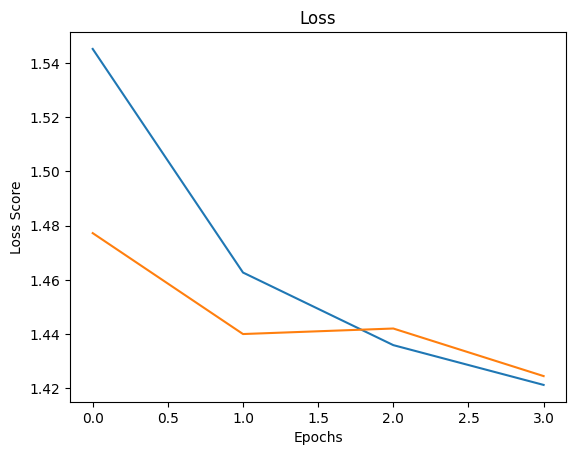

In [16]:
plot(lst[3],lst[7],"Loss")

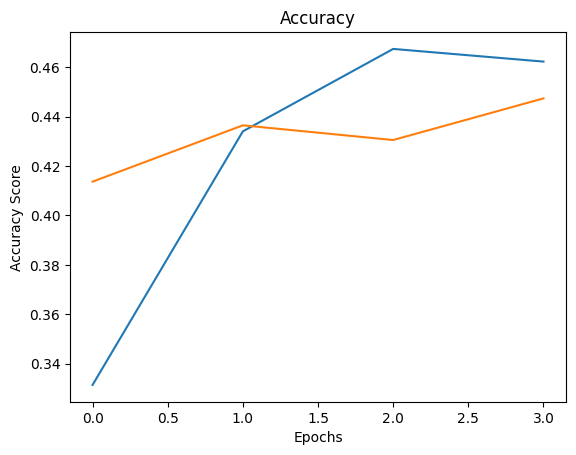

In [17]:
plot(lst[0],lst[4],"Accuracy")

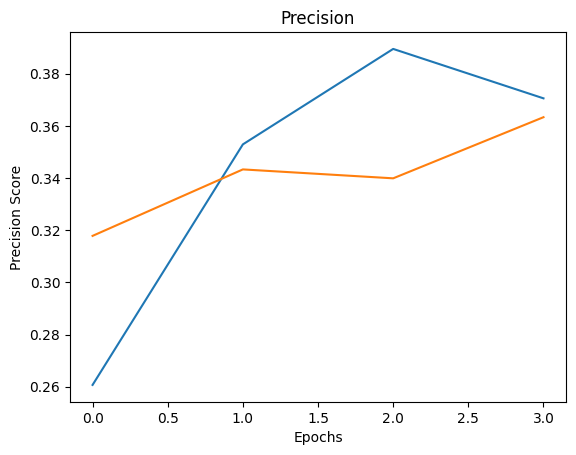

In [18]:
plot(lst[1],lst[5],"Precision")

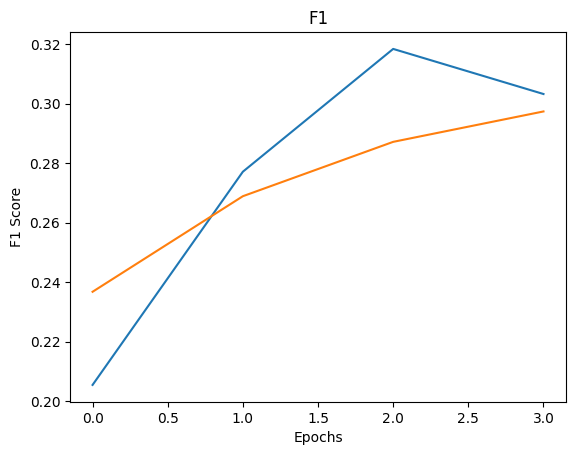

In [19]:
plot(lst[2],lst[6],"F1")

In [21]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from tqdm import tqdm

In [28]:
print(os.listdir("/content/drive/MyDrive/DL_project/TRAIN"))

['TRAIN_3', 'TRAIN_2', 'TRAIN_1', 'TRAIN_4', 'TRAIN_0']


In [29]:
print(os.listdir("/content/drive/MyDrive/DL_project/TEST"))

['TEST_2', 'TEST_0', 'TEST_4', 'TEST_1', 'TEST_3']


110it [02:43,  1.49s/it]


Testing ,Running Loss 1.4291921951554039 ,Accuracy:0.4356060606060604,Precision:0.28333585858585847,F1:0.24939838822793367


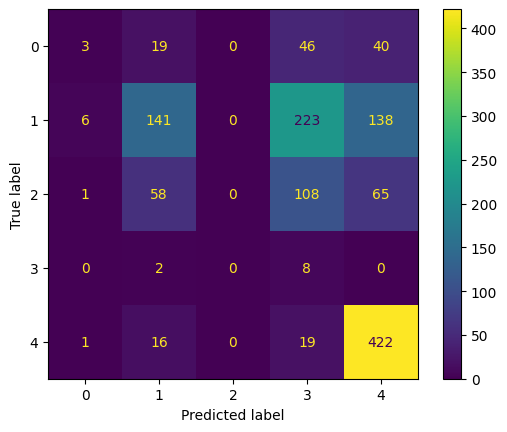

In [31]:
from sklearn.model_selection import train_test_split
train_data=os.listdir("/content/drive/MyDrive/DL_project/TEST")
train_data_2=[0,0,0,0,0]
train_data_2[0]=train_data[-1]
train_data_2[1]=train_data[0]
train_data_2[2]=train_data[3]
train_data_2[3]=train_data[2]
train_data_2[4]=train_data[1]
all_paths=[]
all_labels=[]
for i,path in enumerate(train_data_2):
    full_path="/content/drive/MyDrive/DL_project/TEST/"+path+"/"
    lst=os.listdir(full_path)
    lst=[full_path+i for i in lst]
    all_paths.extend(lst)
    all_labels.extend([i for j in range(len(lst))])
all_paths=np.array(all_paths)
all_labels=np.array(all_labels)
test_dataset=DataSet(all_paths,all_labels,trans)
test_loader=DataLoader(test_dataset,batch_size=12,shuffle=True)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()
with torch.no_grad():
    total_loss = 0
    test_acc=0
    test_prec=0
    test_f1=0
    testing_pred=None
    testing_out=None
    for i,(inputs, targets) in tqdm(enumerate(test_loader)):
        outputs = model(inputs)
        targets=targets.to(torch.long)
        targets=targets.to('cpu')
        outputs=outputs.to('cpu')
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        outputs=torch.argmax(outputs,dim=1)
        test_acc+=get_acc(outputs,targets)
        test_prec+=get_prec(outputs,targets)
        test_f1+=get_f1(outputs,targets)
        if(testing_pred is None):
            testing_pred=np.array(outputs)
            testing_out=np.array(targets)
        else:
            testing_pred=np.concatenate([testing_pred,np.array(outputs)],axis=0)
            testing_out=np.concatenate([testing_out,np.array(targets)],axis=0)        
    test_acc/=(i+1)
    total_loss/=(i+1)
    test_prec/=(i+1)
    test_f1/=(i+1)
    sen = f"Testing ,Running Loss {total_loss} ,Accuracy:{test_acc},Precision:{test_prec},F1:{test_f1}"
    print(sen)
    cm = confusion_matrix(testing_out,testing_pred, labels=[i for i in range(5)])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[i for i in range(5)])
    disp.plot()
    plt.show()

In [ ]:
import pickle
def save_model(list_models,filename):
    pickle.dump(list_models, open(filename, 'wb'))
def load_model(filename):
    list_models=pickle.load(open(filename, 'rb'))
    return list_models


In [ ]:
filename='Weights/Resnet'
save_model(model,filename)

In [ ]:
model=load_model(filename)

In [32]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(testing_out,testing_pred)
print("Kappa score:", kappa)

Kappa score: 0.25011941605166765
